## Пункт 1

In [7]:
library(ggplot2)
library(dplyr)
library(emmeans)

df <- read.csv('CARS.csv')
conf_level = 0.99
alpha <- 1 - conf_level

## 1
model <- aov(MPG_Highway ~ Type, data = df)
summary(model)

             Df Sum Sq Mean Sq F value Pr(>F)    
Type          5   6743  1348.7   77.64 <2e-16 ***
Residuals   422   7331    17.4                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

p-value < 0.01, значит, есть статистически значимые различия в средних значениях расхода топлива на шоссе между различными типами кузова

## Пункты 2-3

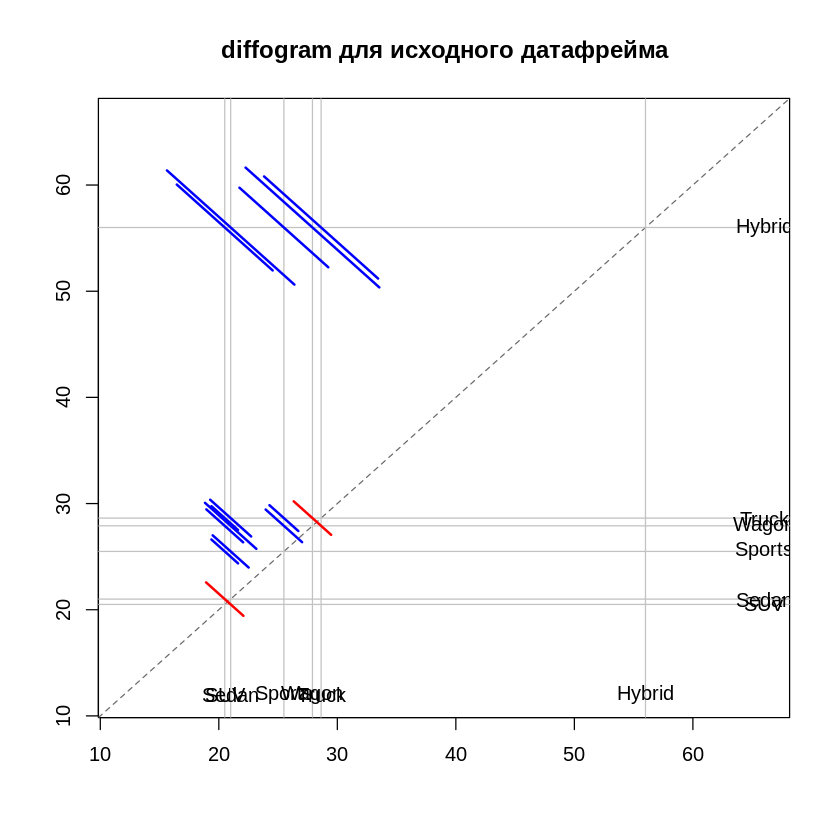

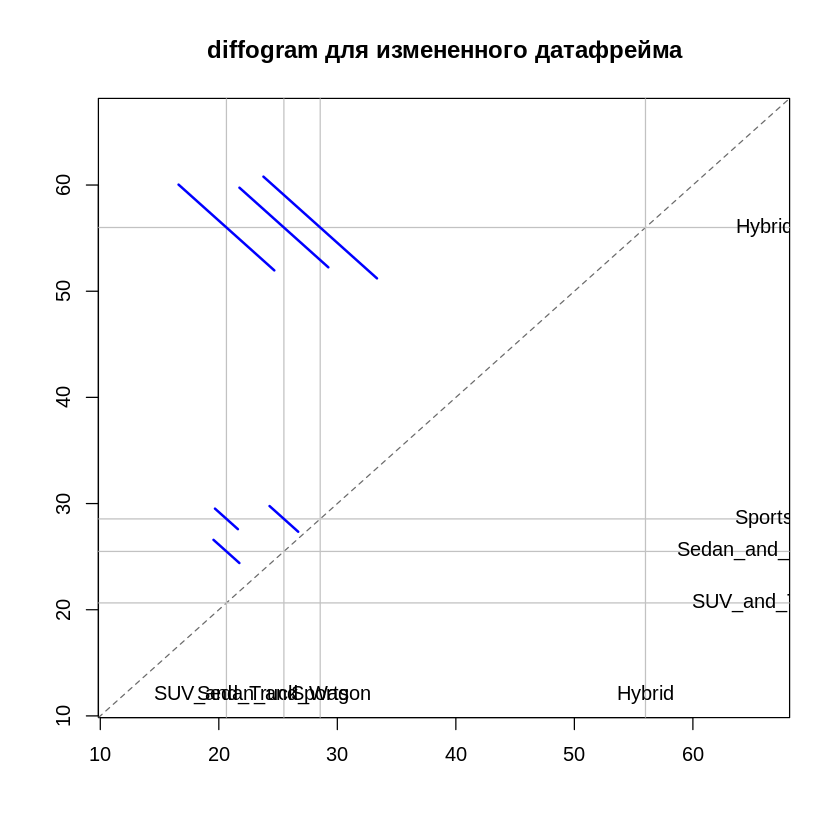

In [10]:
diffogram <- function(f, df, conf.level, title='')
{
  alpha <- 1 - conf.level
  parameters <- all.vars(f)
  predictor <- parameters[2]
  response <- parameters[1]
  mean_vec = c()
  types <- unique(df[[predictor]])

  for (type in types)
  {
    mean_vec <- c(mean_vec, mean(df[df[[predictor]] == type,][[response]]))
  }

  types_with_mean_MPG <- data.frame(types,mean_vec)
  types_with_mean_MPG <- types_with_mean_MPG[order(types_with_mean_MPG$mean_vec),]

  n = length(types)

  xlim = min(df[[response]]):max(df[[response]])
  ylim = xlim

  plot(xlim, ylim, main = title, xlab = "", ylab = "", type = "n")

  #диагональная линия
  abline(0,1,col = 'gray42',lty = 2)

  #вертикальная разметка
  for (i in 1:n)
  {
    abline(v = mean_vec[i], col = 'gray76', lty = 1, lwd = 1)
    text(mean_vec[i],min(ylim),types_with_mean_MPG[i,1])
  }

  #горизонтальная разметка
  for (i in 1:n)
  {
    abline(h = mean_vec[i], col = 'gray76', lty = 1, lwd = 1)
    text(max(xlim),mean_vec[i],types_with_mean_MPG[i,1])
  }
  # находим доверительные интервалы для разности средних
  for (i in 1:(n-1))
  {
    for (j in (i+1):n)
    {
      data <- df[df[[predictor]] == types_with_mean_MPG[i,1] | df[[predictor]] == types_with_mean_MPG[j,1],]
      result <- t.test(data[[response]] ~ data[[predictor]], conf.level = conf_level, var.equal = TRUE)
      l <- c(result$conf.int[1],result$conf.int[2])
      length_of_l <- result$conf.int[2] - result$conf.int[1]
      add <- (length_of_l*sqrt(2))/4
      x0 <- types_with_mean_MPG[i,2] - add
      y0 <- types_with_mean_MPG[j,2] + add
      x1 <- types_with_mean_MPG[i,2] + add
      y1 <- types_with_mean_MPG[j,2] - add


      if (result$p.value > alpha)
      {color = 'red'} else color = 'blue'
      #print(unique(data[[predictor]]))
      #print(c(l[1],l[2]))
      #print(c(x0,y0,x1,y1))
      segments(x0,y0,x1,y1,col = color, lwd = 2)
    }
  }
}

diffogram(f = MPG_Highway ~ Type, df = df, conf.level = conf_level, title = "diffogram для исходного датафрейма")

# объединяем "неразличимые группы"
new_df <- df
new_df$Type[df$Type == "Truck" | df$Type == "SUV" ] <- "SUV_and_Truck"
new_df$Type[df$Type == "Sedan" | df$Type == "Wagon" ] <- "Sedan_and_Wagon"

# строим диффограмму для измененного датафрейма
diffogram(f = MPG_Highway ~ Type, df = new_df, conf.level = conf_level, title = "diffogram для измененного датафрейма")

## Пункт 4

In [11]:
model_with_interaction <- aov(MPG_Highway ~ Type*Origin, data = df)
summary(model_with_interaction)

             Df Sum Sq Mean Sq F value   Pr(>F)    
Type          5   6743  1348.7  81.749  < 2e-16 ***
Origin        2    445   222.3  13.477 2.14e-06 ***
Type:Origin   7     73    10.4   0.629    0.732    
Residuals   413   6814    16.5                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Для переменной Origin p-value < 0.01, значит, есть статистически значимые различия в средних значениях расхода топлива на шоссе между различными странами-производителями. Соответственно, добавление предиктора Origin улучшает модель

## Пункт 5

`summarise()` has grouped output by 'Type'. You can override using the
`.groups` argument.


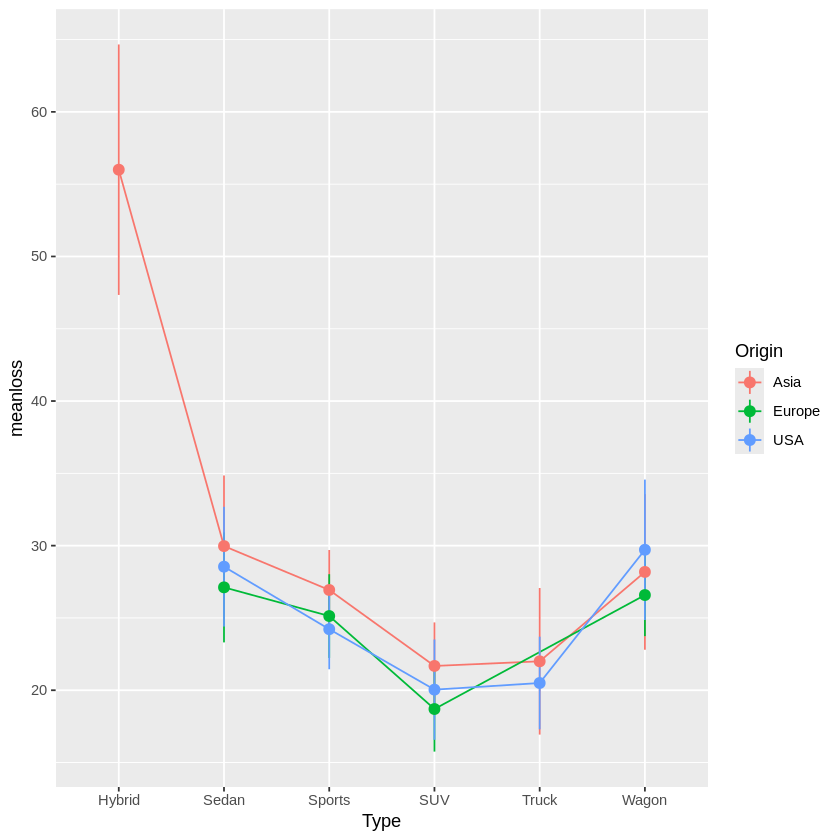

In [13]:
#строим график для проверки взаимодействия переменных
plot_interaction <- function(df){
  na.omit(df) %>% group_by(Type, Origin) %>%
    summarise(meanloss = mean(MPG_Highway), sd = sd(MPG_Highway)) %>%
    ggplot(aes(x = Type, y = meanloss, colour = Origin)) +
  geom_line(aes(group = Origin)) +
  geom_pointrange(aes(ymin = meanloss - sd, ymax = meanloss + sd))
}

plot_interaction(df)


In [14]:
#проверяем с помощью AIC, нужен ли эффект взаимодействия
print(c(AIC_No_Interaction = AIC(model), AIC_With_Interaction = AIC(model_with_interaction)))

  AIC_No_Interaction AIC_With_Interaction 
            2444.452             2431.131 


Графики взаимодействия переменных имеют пересечения и AIC для модели с эффектом взаимодействия принимает меньшее значение, чем модель без эффекта, значит, оставляем модель с эффектом взаимодействия

## Пункт 6

In [22]:
filtered_cars <- filter(df, (Type == "Sedan" & (Origin == "Asia" | Origin == "Europe")) | (Origin == "USA" & Type == "Truck"))
filtered_cars$Group <- ifelse(filtered_cars$Origin == "USA", 2, 1)

# проверяем гипотезу с помощью aov
model_EA_vs_USA <- aov(MPG_Highway ~ Group, data = filtered_cars)
summary(model_EA_vs_USA)

# проверяем гипотезу с помощью констрастов
emm <- emmeans(model_EA_vs_USA, ~ Group)
contrast_result <- contrast(emm, "pairwise")
print(contrast_result)

             Df Sum Sq Mean Sq F value   Pr(>F)    
Group         1    978   978.1   47.43 8.51e-11 ***
Residuals   186   3836    20.6                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

 contrast        estimate   SE  df t.ratio p.value
 Group1 - Group2     8.17 1.19 186   6.887  <.0001



p-value < 0.01 в обоих тестах, значит, нулевая гипотеза (средний расход бензина не отличается в группе европейских и азиатских седанов от группы американских траков) не принимается. Следовательно, есть основания считать, что в данных группах средний расход топлива отличается

In [26]:
# проверяем результаты с помощью t-теста
if (var.test(sedans, trucks)$p.value > alpha) var_equal = TRUE else var_equal = FALSE
t.test(MPG_Highway ~ Group, data = filtered_cars, conf_level = conf_level, var.equal = var_equal)


	Two Sample t-test

data:  MPG_Highway by Group
t = 6.887, df = 186, p-value = 8.51e-11
alternative hypothesis: true difference in means between group 1 and group 2 is not equal to 0
95 percent confidence interval:
  5.832847 10.515990
sample estimates:
mean in group 1 mean in group 2 
       28.67442        20.50000 


[1] TRUE


p-value < 0.01, нулевая гипотеза отвергается. Таким образом, полученные результаты совпадают с полученными выше

## Пункт 7

In [27]:
# проверка равенства дисперсии в группах
print(var_equal)

# проверка, что целевая переменная распределена нормально
shapiro.test(filtered_cars$MPG_Highway)

[1] TRUE



	Shapiro-Wilk normality test

data:  filtered_cars$MPG_Highway
W = 0.95487, p-value = 1.067e-05


Для заданного уровня значимости групповые дисперсии равны, но согласно результату теста Шапиро-Уилка гипотеза о нормальности распределения целевой переменной не принимается. Следовательно, требования применимости полученной в пункте 6 модели, с точки зрения нормальности
распределения целевой переменной НЕ выполняются

## Пункт 8

In [28]:
kruskal.test(MPG_Highway ~ Group, data = filtered_cars)


	Kruskal-Wallis rank sum test

data:  MPG_Highway by Group
Kruskal-Wallis chi-squared = 33.725, df = 1, p-value = 6.347e-09


Отвергаем нулевую гипотезу, т. е. расход топлива в рассматриваемых группах различается